<a href="https://colab.research.google.com/github/iopara268/master-class-report/blob/main/FacialExpressionGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT THE LIBRARIES

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import os
import torch.nn.functional as F

MOUNT THE DATASET ON GOOGLE COLAB

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


DEFINE THE PATH TO THE DIRECTORY WHERE THE DATA IS STORED

In [17]:
data_dir = '/content/drive/My Drive/FACE_EXPRESSION/FACE_EXPRESSION/'
folder_path = '/content/drive/My Drive/FACE_EXPRESSION/FACE_EXPRESSION/DATA/'
image_files = [x for x in os.listdir(folder_path) if x.lower().endswith(('png', 'jpg', 'jpeg'))]
print(f'Total images: {len(image_files)}')
files_in_dir = os.listdir(data_dir)
print(f"Files in directory '{data_dir}':", files_in_dir[:10])

Total images: 96
Files in directory '/content/drive/My Drive/FACE_EXPRESSION/FACE_EXPRESSION/': ['test.jpg', 'DATA', 'LABEL', 'Apex Stills']


In [18]:
base_dir = '/content/drive/My Drive/FACE_EXPRESSION/FACE_EXPRESSION'
data_dir = os.path.join(base_dir, 'DATA')

VISUALIZE 10 RANDOM IMAGES IN THE DATASET

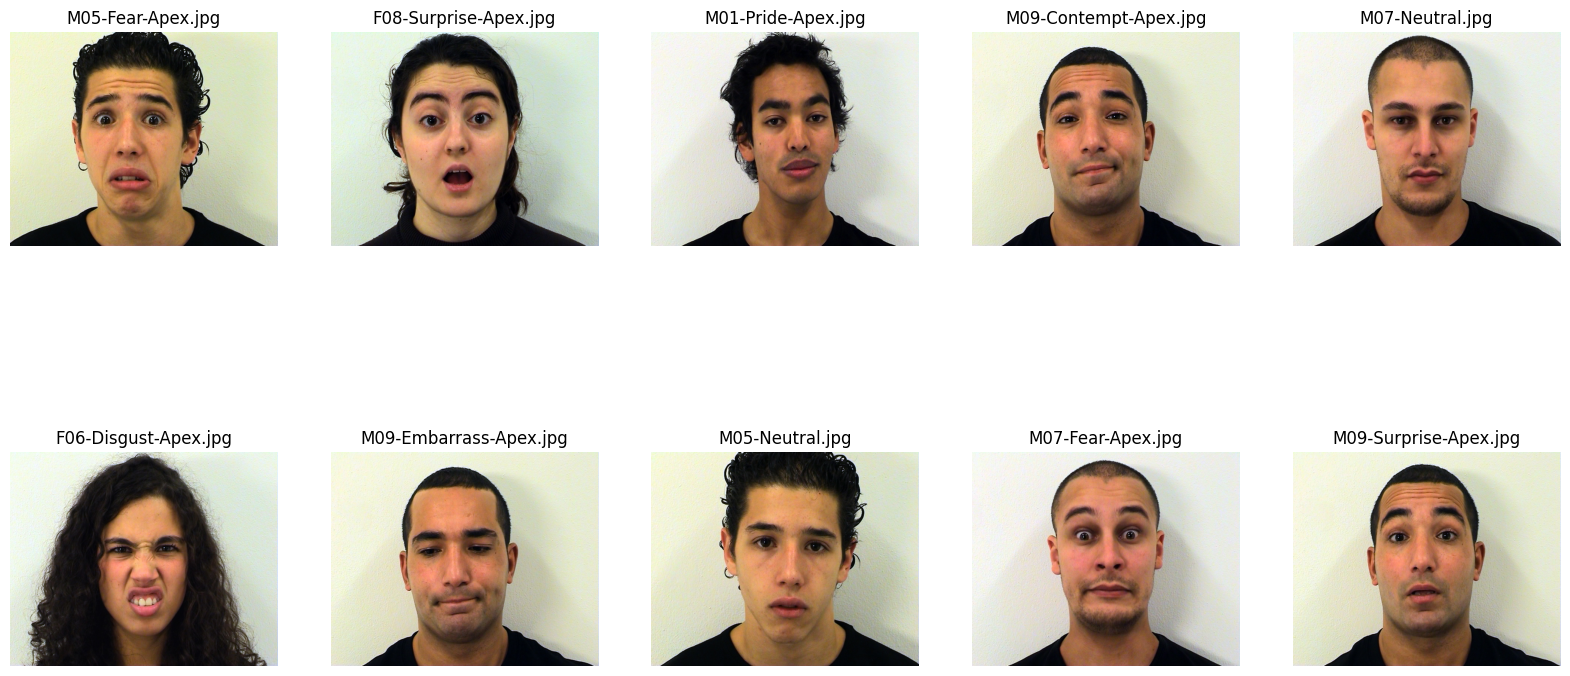

In [19]:
import random

image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

random_images = random.sample(image_files, 10)

plt.figure(figsize=(20, 10))
for i, img_path in enumerate(random_images):
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
plt.show()

IMAGE PREPROCESSING

In [20]:
img_list = []
file_name_list = []
label_list = []
label_name_list = []

LOAD IMAGES

In [21]:
for img_name in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img_name)
    input_img = np.array(Image.open(img_path).resize((192, 192)).convert('L'))
    file_name_list.append(img_name)
    img_list.append(input_img)

LOAD LABELS

In [22]:
label_dir = os.path.join(base_dir, 'LABEL')
for file_name in file_name_list:
    base_name = file_name.split("-")[0]
    for label_name in os.listdir(label_dir):
        if label_name.startswith(base_name):
            label_path = os.path.join(label_dir, label_name)
            output_label = np.array(Image.open(label_path).resize((192, 192)).convert('L'))
            label_list.append(output_label)
            label_name_list.append(label_name)

input_array = np.array(img_list)
output_array = np.array(label_list)

input_tensor = torch.tensor(input_array).float().reshape(-1, 1, 192, 192) / 255
output_tensor = torch.tensor(output_array).float().reshape(-1, 1, 192, 192) / 255
numbers = list(range(len(input_tensor)))
train_idx = random.sample(numbers, int(0.625 * len(numbers)))
test_idx = [num for num in numbers if num not in train_idx]

train_img = input_tensor[train_idx]
train_label = output_tensor[train_idx]

test_img = input_tensor[test_idx]
test_label = output_tensor[test_idx]

MODEL DEFINITION

In [23]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 12 * 12, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc2(x)
        logvar = self.fc3(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 128 * 12 * 12)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(-1, 128, 12, 12)
        x = self.deconv_layers(z)
        return x

class GenerativeModel(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(GenerativeModel, self).__init__()
        self.encoder = Encoder(hidden_size, latent_size)
        self.decoder = Decoder(hidden_size, latent_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


TRAINING AND VISUALIZATION

In [24]:
def train(model, dataloader, optimizer, epoch, device="cuda"):
    model.train()
    train_loss = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, target, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch}, Loss: {avg_loss:.4f}')

dataset = TensorDataset(train_img, train_label)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

hidden_size = 512
latent_size = 64
model = GenerativeModel(hidden_size, latent_size).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 80

for epoch in range(1, num_epochs + 1):
    train(model, dataloader, optimizer, epoch)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

TRAINING AND VISUALIZATION REWRITING THE CODE TO RUN WITH OUT THE NEED FOR THE NVIDIA SOFTWARE

Epoch: 1, Loss: 24682.0044
Epoch: 2, Loss: 23732.3796
Epoch: 3, Loss: 22866.4488
Epoch: 4, Loss: 22102.4852
Epoch: 5, Loss: 21486.1848
Epoch: 6, Loss: 20898.9655
Epoch: 7, Loss: 20432.5315
Epoch: 8, Loss: 20051.1010
Epoch: 9, Loss: 19779.7333
Epoch: 10, Loss: 19635.8569
Epoch: 11, Loss: 19478.9068
Epoch: 12, Loss: 19361.3629
Epoch: 13, Loss: 19307.6457
Epoch: 14, Loss: 19235.9094
Epoch: 15, Loss: 19158.2600
Epoch: 16, Loss: 19101.8129
Epoch: 17, Loss: 19051.9794
Epoch: 18, Loss: 19017.0109
Epoch: 19, Loss: 18967.5165
Epoch: 20, Loss: 18920.6905
Epoch: 21, Loss: 18890.4445
Epoch: 22, Loss: 18851.4941
Epoch: 23, Loss: 18811.9897
Epoch: 24, Loss: 18771.7535
Epoch: 25, Loss: 18740.7427
Epoch: 26, Loss: 18711.1964
Epoch: 27, Loss: 18677.6953
Epoch: 28, Loss: 18646.6500
Epoch: 29, Loss: 18638.2818
Epoch: 30, Loss: 18684.4923
Epoch: 31, Loss: 18611.5396
Epoch: 32, Loss: 18544.6762
Epoch: 33, Loss: 18510.4953
Epoch: 34, Loss: 18480.2306
Epoch: 35, Loss: 18452.8211
Epoch: 36, Loss: 18439.4048
E

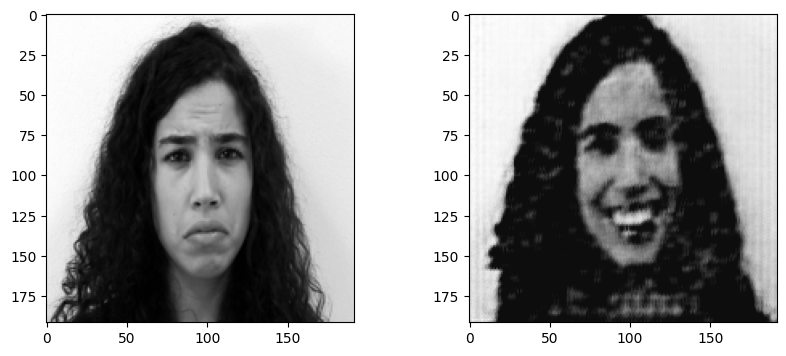

In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

def train(model, dataloader, optimizer, epoch, device):
    model.train()
    train_loss = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, target, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch}, Loss: {avg_loss:.4f}')


dataset = TensorDataset(train_img, train_label)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


hidden_size = 512
latent_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenerativeModel(hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 80
for epoch in range(1, num_epochs + 1):
    train(model, dataloader, optimizer, epoch, device)

plt.figure(figsize=[10, 4])

plt.subplot(1, 2, 1)
test_sample = np.array(test_img[1][0].to(device).detach())
plt.imshow(test_sample, cmap="gray")


plt.subplot(1, 2, 2)
test_input = test_img[1][0].reshape(1, 1, 192, 192).to(device)
test_result = model(test_input)[0]
test_result = np.array(test_result.reshape(192, 192).to(device).detach())
plt.imshow(test_result, cmap="gray")

plt.show()


TESTING(WILD TESTING)

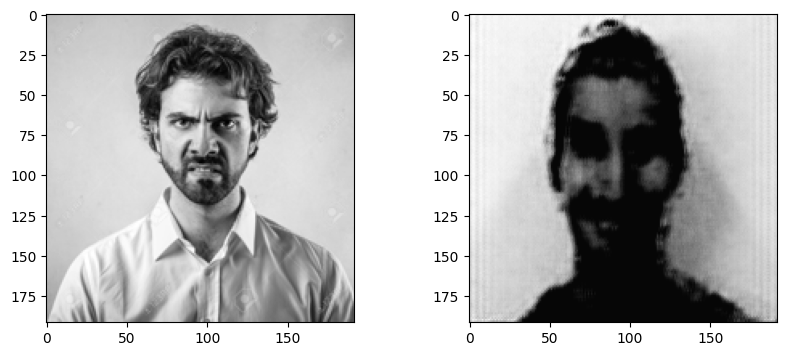

In [33]:
data_dir = '/content/drive/My Drive/FACE_EXPRESSION/FACE_EXPRESSION/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=[10, 4])

plt.subplot(1, 2, 1)
wild_test_sample = np.array(Image.open(data_dir + '/test.jpg').resize((192, 192)).convert('L'))
plt.imshow(wild_test_sample, cmap="gray")

plt.subplot(1, 2, 2)
wild_test_sample = torch.tensor(wild_test_sample).unsqueeze(0).unsqueeze(0).float() / 255.0
wild_test_sample = wild_test_sample.to(device)
wild_test_result = model(wild_test_sample)[0]
wild_test_result = wild_test_result.to('cpu').detach().numpy().reshape(192, 192)
plt.imshow(wild_test_result, cmap="gray")

plt.show()

TO EVALUATE THE MODEL USING MEAN SQUARE ERROR

In [34]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    mse_loss = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, target, mu, log_var)
            total_loss += loss.item()


            mse_loss += mean_squared_error(target.cpu().numpy().flatten(), recon_batch.cpu().numpy().flatten())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_mse = mse_loss / len(dataloader)
    print(f'Avg Loss: {avg_loss:.4f}, Avg MSE: {avg_mse:.4f}')
    return avg_loss, avg_mse

train_dataset = TensorDataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
train_loss, train_mse = evaluate_model(model, train_dataloader, device)

test_dataset = TensorDataset(test_img, test_label)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
test_loss, test_mse = evaluate_model(model, test_dataloader, device)


Avg Loss: 17595.1165, Avg MSE: 0.0186
Avg Loss: 17765.7376, Avg MSE: 0.0224


TO IMPROVE THE MODEL BY UPDATING THE LEARNING RATE

In [16]:
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, label_list, transform=None):
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = self.img_list[idx]
        label = self.label_list[idx]


        image = Image.fromarray((image.squeeze() * 255).astype(np.uint8), mode='L')
        label = Image.fromarray((label.squeeze() * 255).astype(np.uint8), mode='L')

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

train_dataset_aug = CustomDataset(train_img.cpu().numpy(), train_label.cpu().numpy(), transform=transform)
test_dataset_aug = CustomDataset(test_img.cpu().numpy(), test_label.cpu().numpy(), transform=transform)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=8, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 80
for epoch in range(1, num_epochs + 1):
    train(model, train_loader_aug, optimizer, epoch, device)
    scheduler.step()

test_loss, test_mse = evaluate_model(model, test_loader_aug, device)


Epoch: 1, Loss: 21028.3806
Epoch: 2, Loss: 20039.0473
Epoch: 3, Loss: 19733.7197
Epoch: 4, Loss: 19826.7618
Epoch: 5, Loss: 19591.1961
Epoch: 6, Loss: 19647.8471
Epoch: 7, Loss: 19561.5038
Epoch: 8, Loss: 19506.3642
Epoch: 9, Loss: 19631.4785
Epoch: 10, Loss: 19535.3319
Epoch: 11, Loss: 19496.5686
Epoch: 12, Loss: 19522.2392
Epoch: 13, Loss: 19665.5754
Epoch: 14, Loss: 19548.9659
Epoch: 15, Loss: 19405.5357
Epoch: 16, Loss: 19395.6346
Epoch: 17, Loss: 19563.9424
Epoch: 18, Loss: 19567.3187
Epoch: 19, Loss: 19553.9673
Epoch: 20, Loss: 19340.5094
Epoch: 21, Loss: 19432.3574
Epoch: 22, Loss: 19503.1919
Epoch: 23, Loss: 19455.4875
Epoch: 24, Loss: 19559.9018
Epoch: 25, Loss: 19419.0062
Epoch: 26, Loss: 19554.5742
Epoch: 27, Loss: 19304.6249
Epoch: 28, Loss: 19537.7154
Epoch: 29, Loss: 19464.4004
Epoch: 30, Loss: 19423.5380
Epoch: 31, Loss: 19330.5871
Epoch: 32, Loss: 19384.3678
Epoch: 33, Loss: 19433.3469
Epoch: 34, Loss: 19337.7918
Epoch: 35, Loss: 19609.7424
Epoch: 36, Loss: 19403.9495
E

REWRITING THE CODE TO IMPROVE THE RESULTS
(HYPERPARAMETER TUNING WITH LEARNING RATE FINDER)

In [17]:
optimal_lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=optimal_lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 80
for epoch in range(1, num_epochs + 1):
    train(model, train_loader_aug, optimizer, epoch, device)
    scheduler.step()

test_loss, test_mse = evaluate_model(model, test_loader_aug, device)
print(f'Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}')


Epoch: 1, Loss: 19503.7895
Epoch: 2, Loss: 19480.3551
Epoch: 3, Loss: 19789.1276
Epoch: 4, Loss: 19533.5457
Epoch: 5, Loss: 19509.9174
Epoch: 6, Loss: 19453.0504
Epoch: 7, Loss: 19504.5710
Epoch: 8, Loss: 19265.9648
Epoch: 9, Loss: 19429.7733
Epoch: 10, Loss: 19481.2260
Epoch: 11, Loss: 19229.1522
Epoch: 12, Loss: 19526.4551
Epoch: 13, Loss: 19420.7553
Epoch: 14, Loss: 19198.7559
Epoch: 15, Loss: 19433.8212
Epoch: 16, Loss: 19502.9090
Epoch: 17, Loss: 19463.9707
Epoch: 18, Loss: 19509.6871
Epoch: 19, Loss: 19378.1919
Epoch: 20, Loss: 19197.7109
Epoch: 21, Loss: 19316.5193
Epoch: 22, Loss: 19396.8980
Epoch: 23, Loss: 19269.2039
Epoch: 24, Loss: 19163.6311
Epoch: 25, Loss: 19294.9229
Epoch: 26, Loss: 19243.8497
Epoch: 27, Loss: 19369.1145
Epoch: 28, Loss: 19373.1525
Epoch: 29, Loss: 19287.9913
Epoch: 30, Loss: 19290.4191
Epoch: 31, Loss: 19288.6434
Epoch: 32, Loss: 19252.5884
Epoch: 33, Loss: 19202.7048
Epoch: 34, Loss: 19311.9031
Epoch: 35, Loss: 19415.3031
Epoch: 36, Loss: 19385.1723
E

AGAIN TRYING TO IMPROVE THE MODEL

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 12 * 12, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        mu = self.fc2(x)
        logvar = self.fc3(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, 256 * 12 * 12)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = F.relu(self.fc2(z))
        z = z.view(-1, 256, 12, 12)
        x = self.deconv_layers(z)
        return x

class GenerativeModel(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(GenerativeModel, self).__init__()
        self.encoder = Encoder(hidden_size, latent_size)
        self.decoder = Decoder(hidden_size, latent_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
hidden_size = 512
latent_size = 64
model = GenerativeModel(hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=optimal_lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 80
for epoch in range(1, num_epochs + 1):
    train(model, train_loader_aug, optimizer, epoch, device)
    scheduler.step()

test_loss, test_mse = evaluate_model(model, test_loader_aug, device)
print(f'Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}')


Epoch: 1, Loss: 247925.5525
Epoch: 2, Loss: 38157.8523
Epoch: 3, Loss: 28661.8652
Epoch: 4, Loss: 25547.8514
Epoch: 5, Loss: 23137.6628
Epoch: 6, Loss: 22500.4188
Epoch: 7, Loss: 22105.6225
Epoch: 8, Loss: 25625.7568
Epoch: 9, Loss: 22187.9280
Epoch: 10, Loss: 22634.4358
Epoch: 11, Loss: 21732.2740
Epoch: 12, Loss: 21538.4789
Epoch: 13, Loss: 21781.4150
Epoch: 14, Loss: 22253.4461
Epoch: 15, Loss: 21751.1596
Epoch: 16, Loss: 21729.5479
Epoch: 17, Loss: 21583.2371
Epoch: 18, Loss: 21496.0177
Epoch: 19, Loss: 21515.6837
Epoch: 20, Loss: 21441.2259
Epoch: 21, Loss: 21385.1089
Epoch: 22, Loss: 21365.2298
Epoch: 23, Loss: 21346.8046
Epoch: 24, Loss: 21413.0882
Epoch: 25, Loss: 21526.5096
Epoch: 26, Loss: 21396.7650
Epoch: 27, Loss: 21727.4613
Epoch: 28, Loss: 21320.8824
Epoch: 29, Loss: 21293.2879
Epoch: 30, Loss: 21397.2260
Epoch: 31, Loss: 21437.3691
Epoch: 32, Loss: 21492.5378
Epoch: 33, Loss: 21488.7827
Epoch: 34, Loss: 21752.1333
Epoch: 35, Loss: 21456.1092
Epoch: 36, Loss: 21479.1452


INCREASING MODEL COMPLEXITY TO IMPROVE THE MODEL

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 12 * 12, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        mu = self.fc2(x)
        logvar = self.fc3(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, 512 * 12 * 12)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = F.relu(self.fc2(z))
        z = z.view(-1, 512, 12, 12)
        x = self.deconv_layers(z)
        return x


In [ ]:
hidden_size = 512
latent_size = 64
model = GenerativeModel(hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=optimal_lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 80
for epoch in range(1, num_epochs + 1):
    train(model, train_loader_aug, optimizer, epoch, device)
    scheduler.step()

test_loss, test_mse = evaluate_model(model, test_loader_aug, device)
print(f'Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}')


Epoch: 1, Loss: 209295825986.0240
Epoch: 2, Loss: 7540974242168.4004
Epoch: 3, Loss: 17445142717157530.0000
Epoch: 4, Loss: 16070422836.9297
Epoch: 5, Loss: 1255218736.8388
Epoch: 6, Loss: 16316513486.0370
Epoch: 7, Loss: 1070201269.4996
Epoch: 8, Loss: 207948365079.5760
Epoch: 9, Loss: 5557744500962.1875
Epoch: 10, Loss: 140328734.9984
Epoch: 11, Loss: 503220.7118
Epoch: 12, Loss: 146932636.4284
Epoch: 13, Loss: 22010103.8500
Epoch: 14, Loss: 49060551.0799
Epoch: 15, Loss: 16650342581.8563
Epoch: 16, Loss: 194252598.4594
Epoch: 17, Loss: 709429681.2852
Epoch: 18, Loss: 14458284708727904.0000
Epoch: 19, Loss: 550588495.6763
Epoch: 20, Loss: 746683.2615
Epoch: 21, Loss: 3059926901.6426
Epoch: 22, Loss: 342419.5018
Epoch: 23, Loss: 19998719.7703
Epoch: 24, Loss: 885779182147.6270
Epoch: 25, Loss: 43994668.1730
Epoch: 26, Loss: 15297764.4642
Epoch: 27, Loss: 2421431556.8232
Epoch: 28, Loss: 401748932.1875
Epoch: 29, Loss: 122462036.5467
Epoch: 30, Loss: 1300234.2049
Epoch: 31, Loss: 33233